In [ ]:
# RUN THIS IF RUNNING IN COLLAB TO MOUNT FILES
from google.colab import drive
drive.mount('/content/drive')

# change path to folder 'final-proj-381-main' which contains "main.ipynb" and "matchups_full_2025.csv"
%cd /content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Final Project/final-proj-381-main


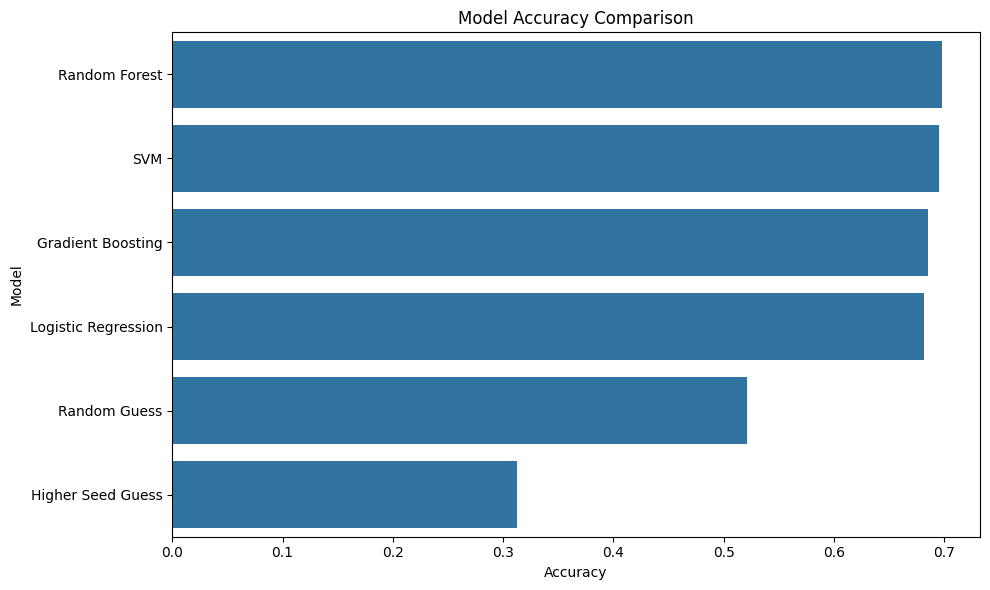

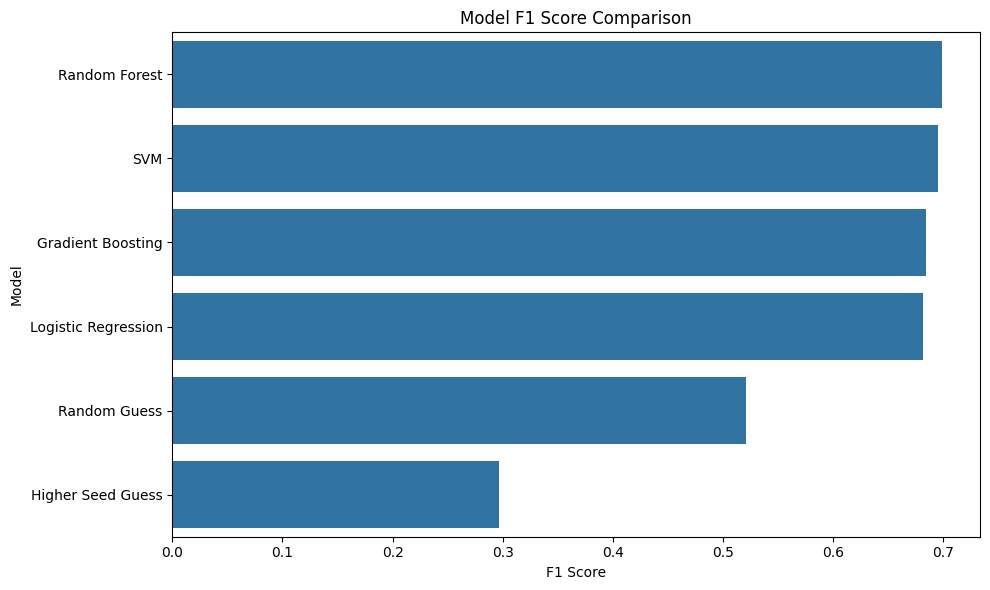

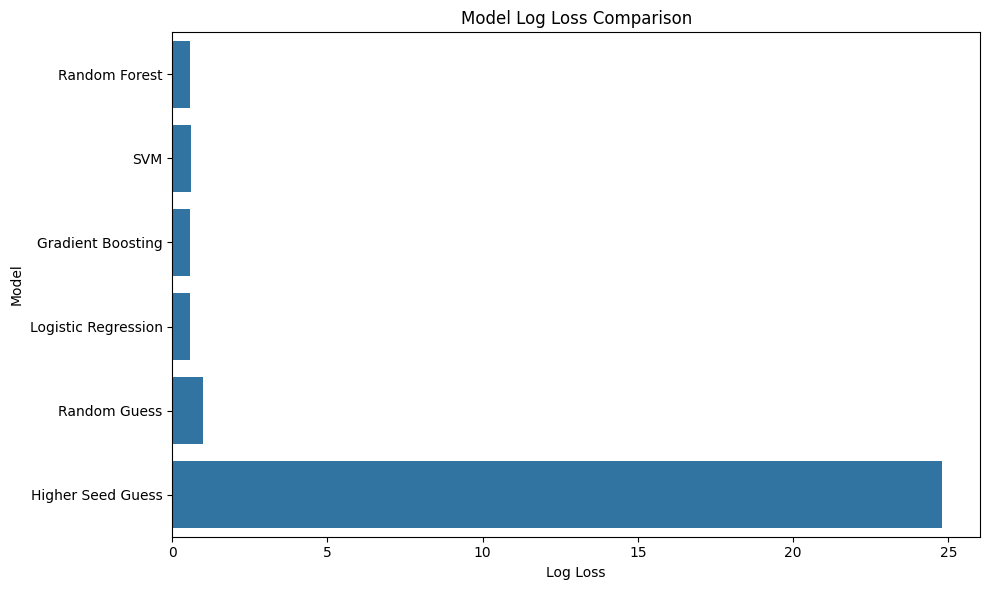

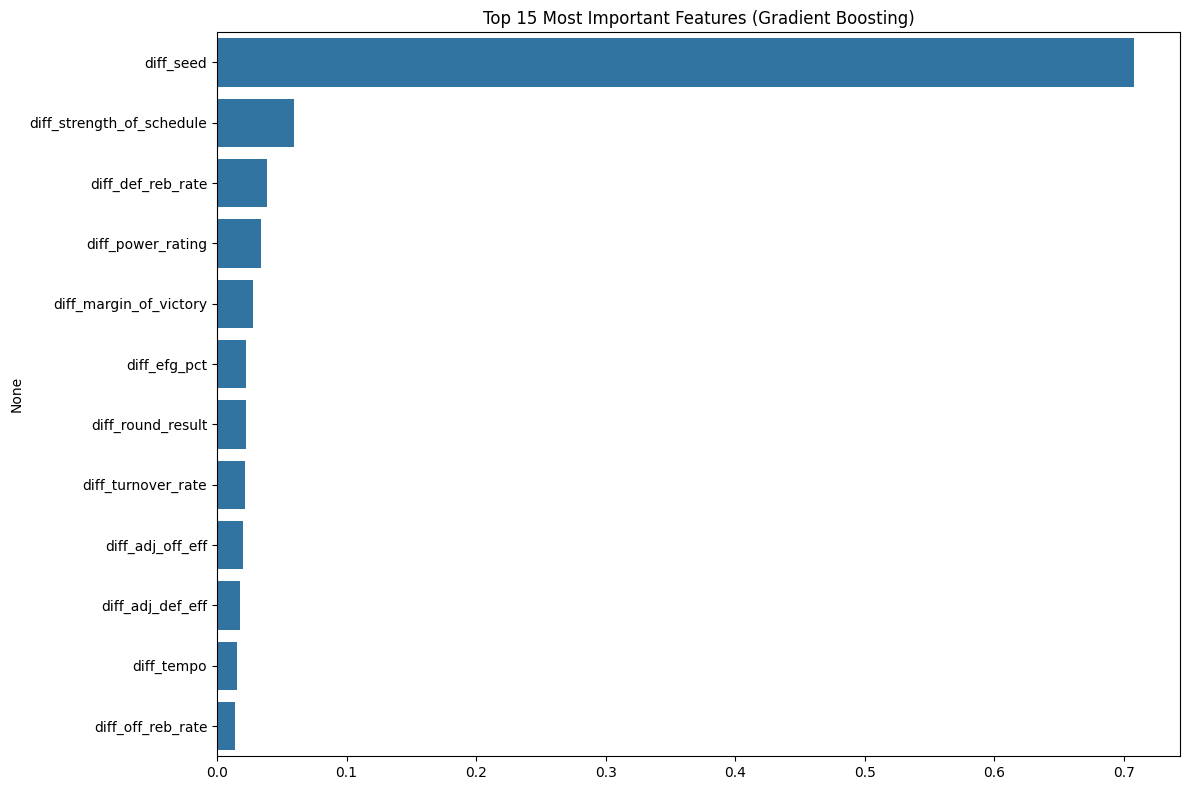

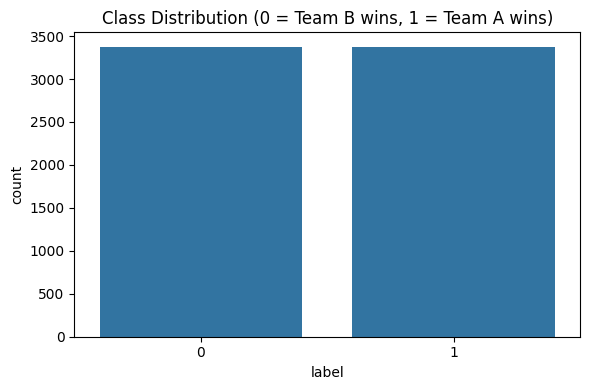

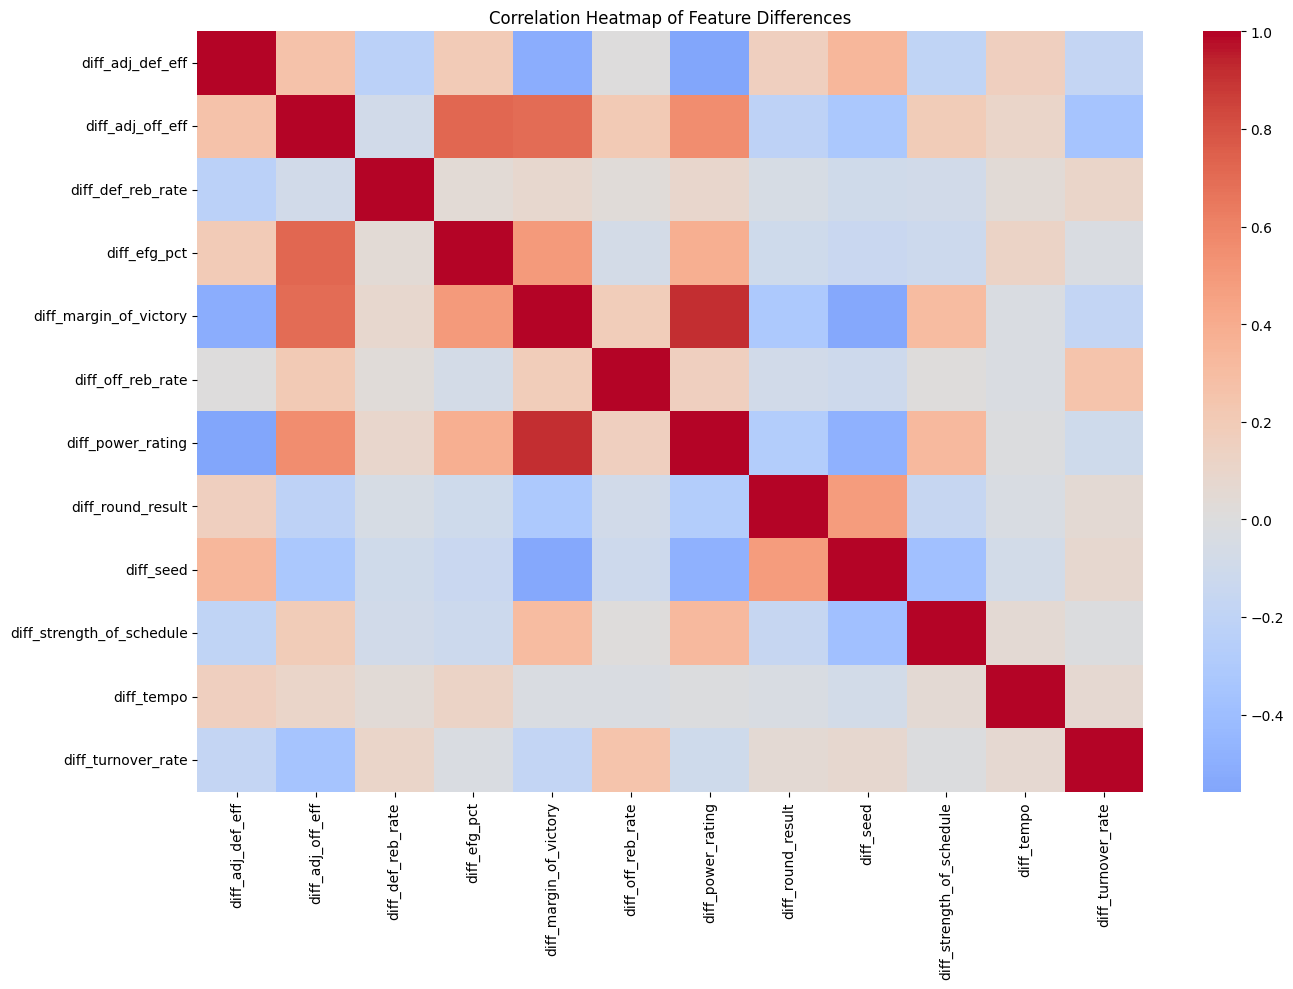

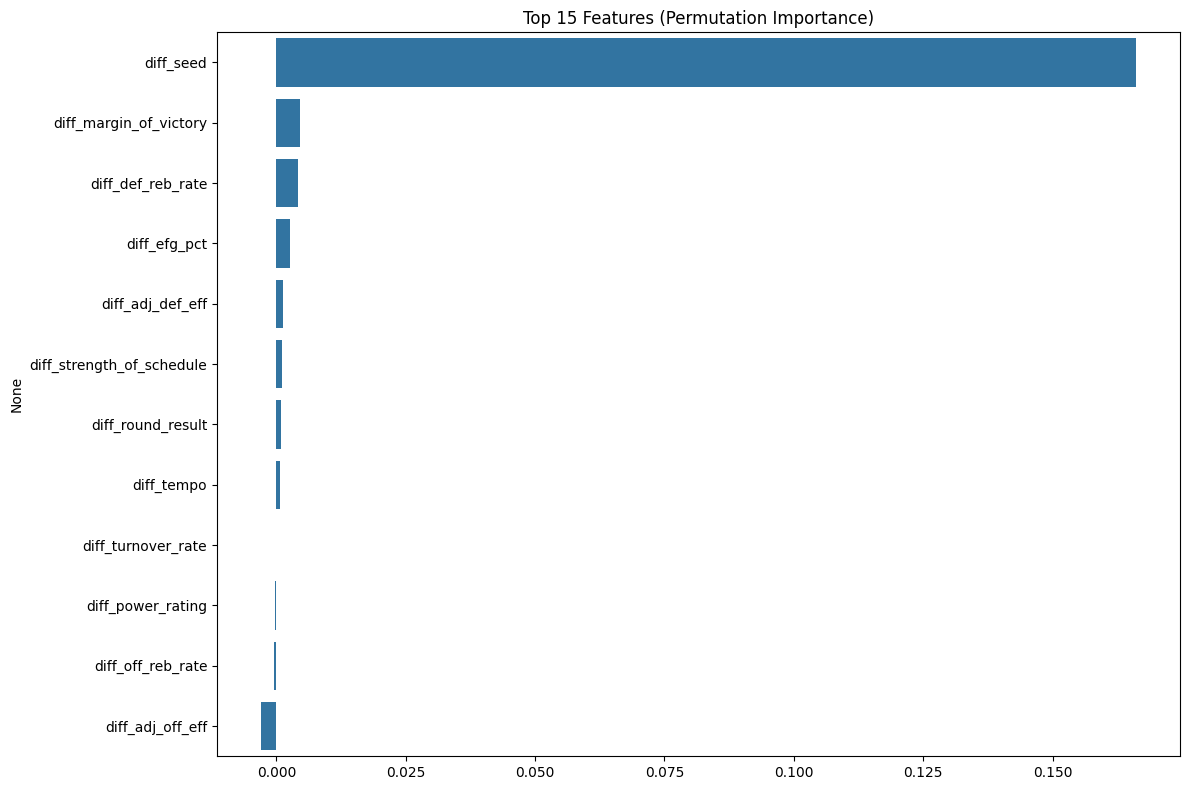

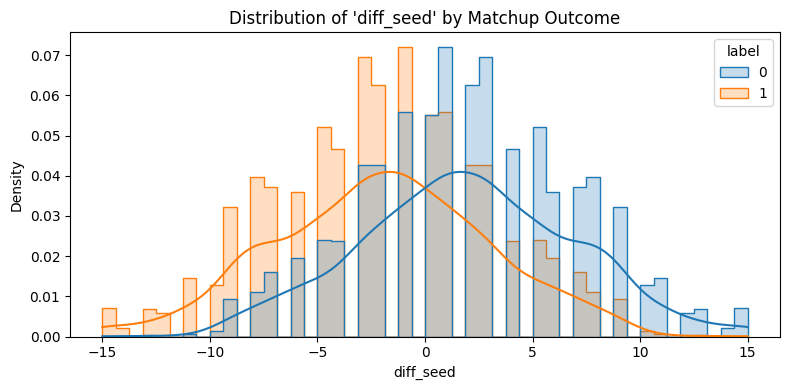

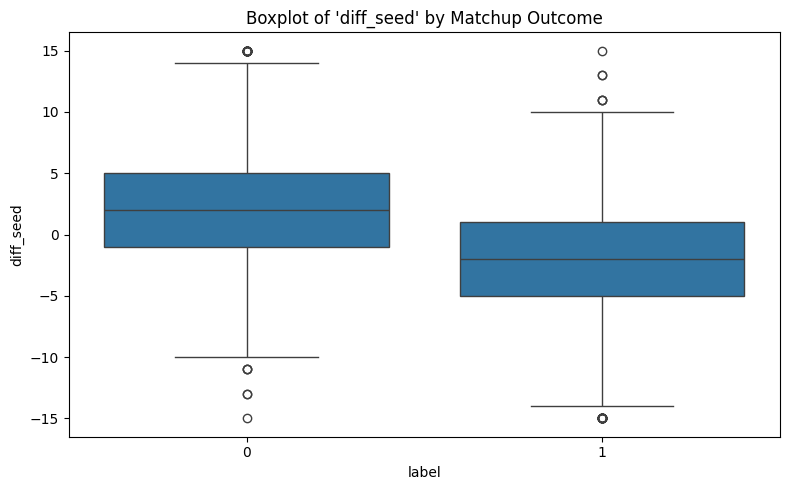

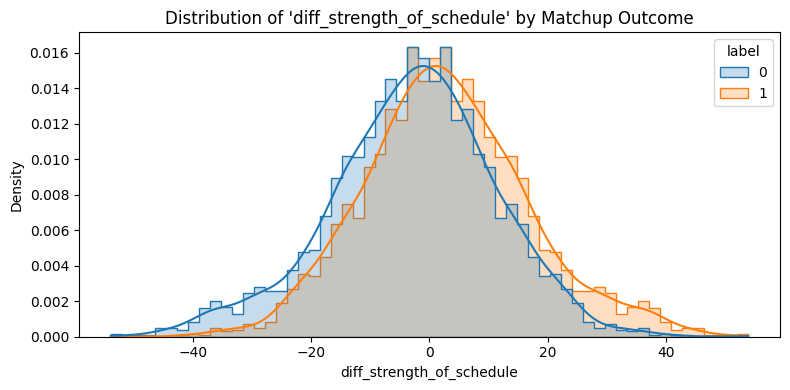

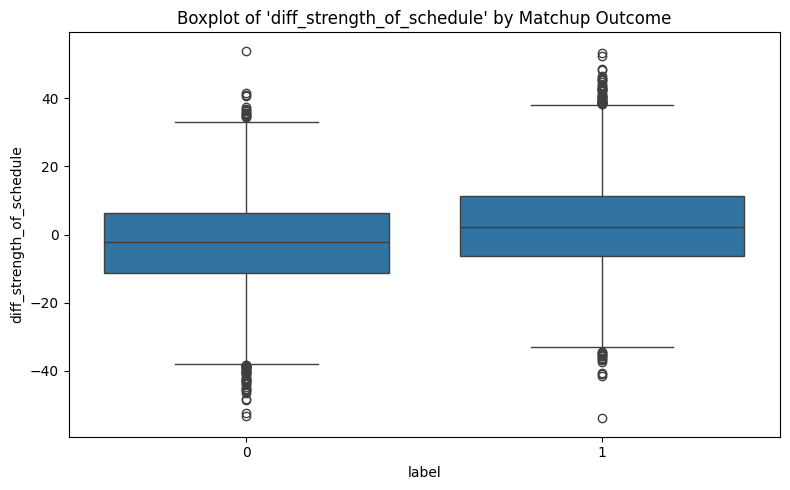

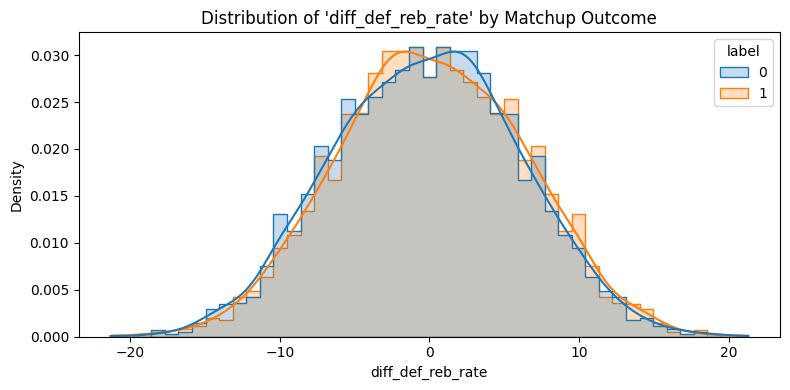

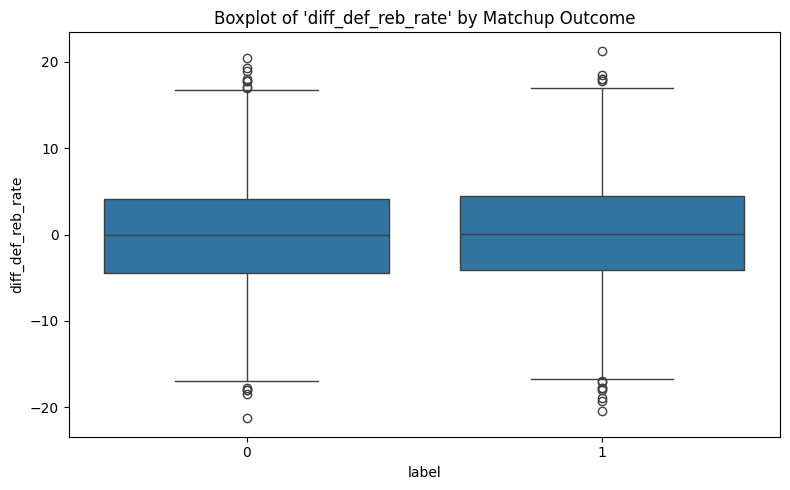

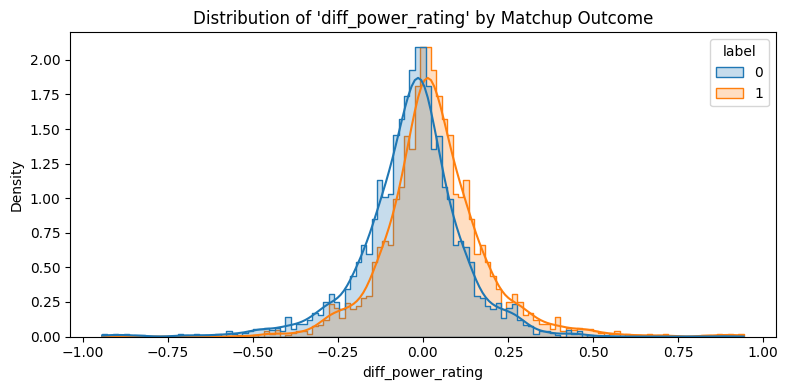

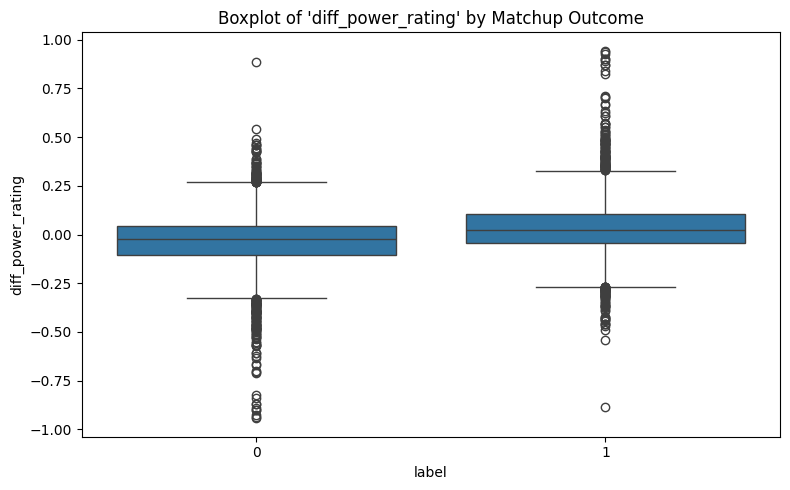

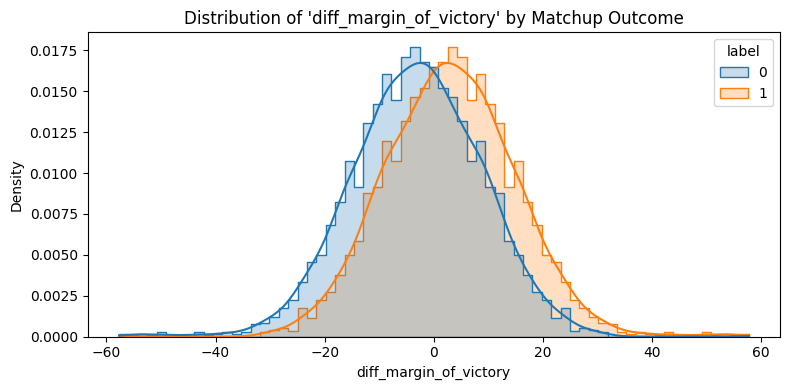

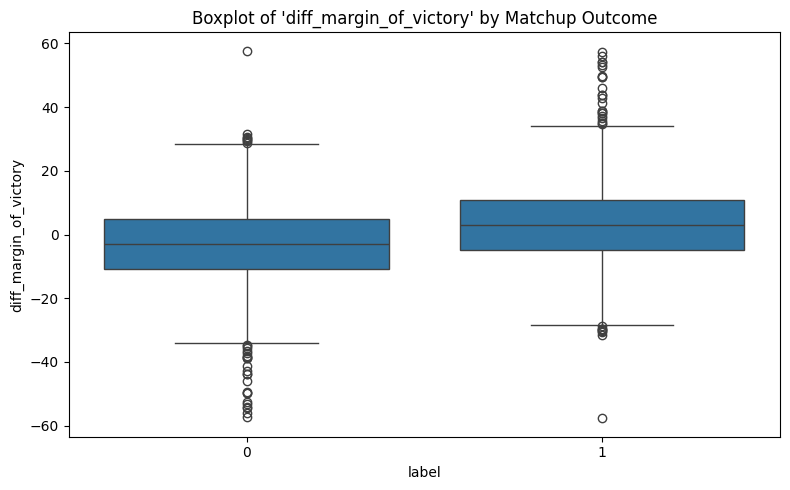

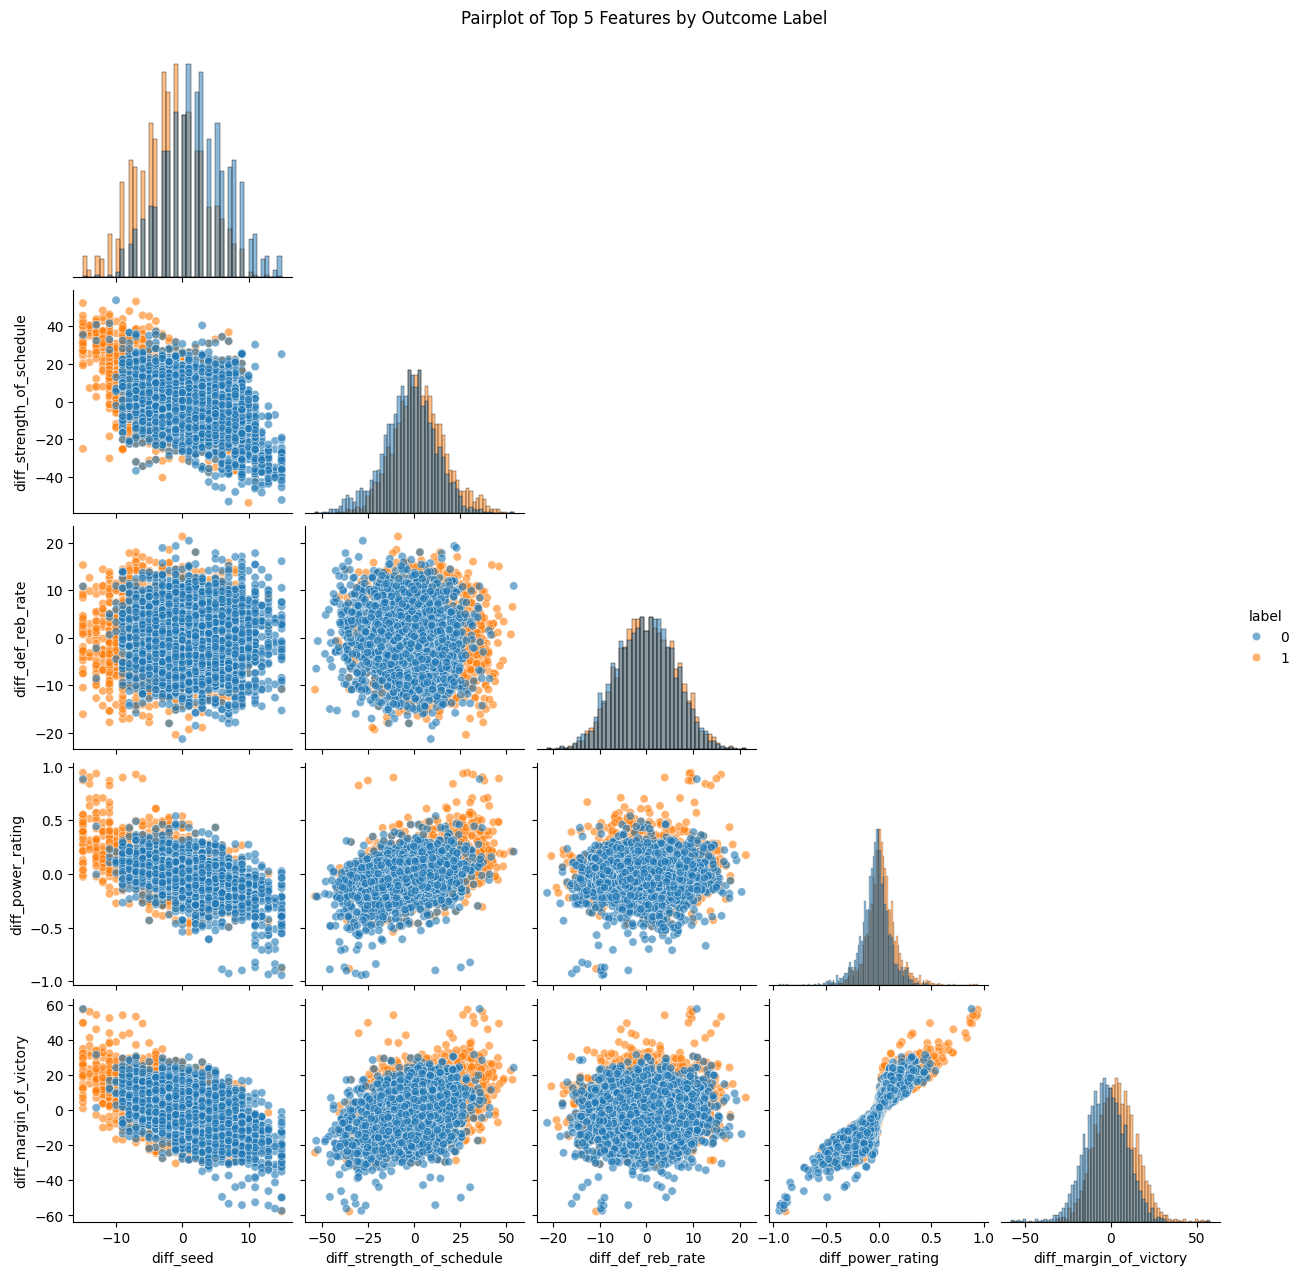

In [114]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.inspection import permutation_importance

# --- Load and Prepare Data ---
df = pd.read_csv("matchups_full_2025.csv")
feature_cols = [col for col in df.columns if col.startswith("diff_")]
X = df[feature_cols]
y = df["label"]

train_mask = df["Tourney"] == 0
test_mask = df["Tourney"] == 1

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]
# --- Models ---
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True))
    ])
}

# --- Evaluate Models ---
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results.append((name,
                    accuracy_score(y_test, y_pred),
                    f1_score(y_test, y_pred),
                    log_loss(y_test, y_prob)))

# --- Baselines ---
seed_pred = (X_test['diff_seed'] > 0).astype(int)
seed_prob = seed_pred.astype(float)
results.append(("Higher Seed Guess",
                accuracy_score(y_test, seed_pred),
                f1_score(y_test, seed_pred),
                log_loss(y_test, seed_prob)))

np.random.seed(42)
rand_pred = np.random.randint(0, 2, len(y_test))
rand_prob = np.random.rand(len(y_test))
results.append(("Random Guess",
                accuracy_score(y_test, rand_pred),
                f1_score(y_test, rand_pred),
                log_loss(y_test, rand_prob)))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score", "Log Loss"])
results_df.sort_values(by="F1 Score", ascending=False, inplace=True)

# --- Save Directory ---
fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)

def save_plot(fig, name):
    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, name + ".png"))
    plt.show()

# --- Plot Performance ---
for metric in ["Accuracy", "F1 Score", "Log Loss"]:
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x=metric, y="Model")
    plt.title(f"Model {metric} Comparison")
    save_plot(fig, metric.lower().replace(" ", "_") + "_comparison")

# --- Feature Importance (Gradient Boosting) ---
best_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

fig = plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_sorted.head(15).values,
            y=feature_importances_sorted.head(15).index)
plt.title("Top 15 Most Important Features (Gradient Boosting)")
save_plot(fig, "feature_importance")

# --- Class Balance ---
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label')
plt.title("Class Distribution (0 = Team B wins, 1 = Team A wins)")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "class_distribution.png"))
plt.show()

# --- Correlation Heatmap ---
fig = plt.figure(figsize=(14, 10))
sns.heatmap(X_train.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Feature Differences")
save_plot(fig, "correlation_heatmap")

# --- Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():
    estimator = model
    acc = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(estimator, X, y, cv=cv, scoring='f1').mean()
    cv_results.append((name, acc, f1))
cv_df = pd.DataFrame(cv_results, columns=["Model", "CV Accuracy", "CV F1 Score"])
cv_df.sort_values(by="CV F1 Score", ascending=False, inplace=True)
cv_df.to_csv("cross_validation_results.csv", index=False)

# --- Summary Stats of Top Features ---
top_5_features = feature_importances_sorted.head(5).index.tolist()
summary_stats = df.groupby("label")[top_5_features].describe().T
summary_stats.to_csv("summary_stats_by_label.csv")

# --- Permutation Importance ---
perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)

fig = plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importances.head(15).values, y=perm_importances.head(15).index)
plt.title("Top 15 Features (Permutation Importance)")
save_plot(fig, "permutation_importance")

# --- Distribution and Boxplots ---
for feature in top_5_features:
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue='label', kde=True, stat='density', element='step')
    plt.title(f"Distribution of '{feature}' by Matchup Outcome")
    save_plot(fig, f"dist_{feature}")

    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='label', y=feature)
    plt.title(f"Boxplot of '{feature}' by Matchup Outcome")
    save_plot(fig, f"boxplot_{feature}")

# --- Pairplot ---
df_top5 = df[top_5_features + ['label']].apply(pd.to_numeric, errors='coerce').dropna()
pairplot = sns.pairplot(df_top5, hue='label', corner=True, diag_kind='hist', plot_kws={'alpha': 0.6})
pairplot.fig.suptitle("Pairplot of Top 5 Features by Outcome Label", y=1.02)
pairplot.savefig(os.path.join(fig_dir, "pairplot_top5_features.png"))
plt.show()
